In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-taxi-trip-duration/train.zip
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip


# 1. Data preparation: 
#### Import libraries


In [91]:
# To display plots directly in the notebook:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import sklearn
import seaborn as sns
import zipfile
import folium
from folium import plugins
from folium.plugins import HeatMap
import haversine as hs 
from geopy.distance import great_circle 
from sklearn.metrics.pairwise import haversine_distances
from math import radians




In [92]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

### Get the data

In [93]:
zf_train = zipfile.ZipFile('../input/nyc-taxi-trip-duration/train.zip')
nyc_train_data = pd.read_csv(zf_train.open('train.csv'))

zf_test = zipfile.ZipFile('../input/nyc-taxi-trip-duration/test.zip')
nyc_test_data = pd.read_csv(zf_test.open('test.csv'))

## Inspection, Engineering and Visualization of Data: 


In [94]:
nyc_train_data.head()


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [95]:
train_length = len(nyc_train_data)
train_length


1458644

The number of instances of the training set is 1 458 644

In [96]:
nyc_train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [97]:
nyc_train_data.describe()


vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01      4.073588e+01   3.970000e+02  
50%        -7.397975e+01      4.075452e+01   6.620000e+02  
75%        -7.396301e+01      4.076981e+01   1.075000e+03  
max        -6.133553e+01      4.392103e+01   3.526282e+06

In [98]:
nyc_train_data.isnull().count()


id                    1458644
vendor_id             1458644
pickup_datetime       1458644
dropoff_datetime      1458644
passenger_count       1458644
pickup_longitude      1458644
pickup_latitude       1458644
dropoff_longitude     1458644
dropoff_latitude      1458644
store_and_fwd_flag    1458644
trip_duration         1458644
dtype: int64

no missing values


In [99]:
nyc_train_data.nunique().count()

11

### Feature overview: 

pickup_datetime and dropoff_datetime have the datatype object --> we need to change the datatype


most of the other features already have required datatypes  

In [100]:
#as the datatype of the datetimes is Object, we first convert it into datetime-datatype and then into new features filtering 
# the hours, minutes and seconds (datatype integer): 

nyc_train_data['pickup_datetime'] = pd.to_datetime(nyc_train_data['pickup_datetime'])
nyc_train_data['dropoff_datetime'] = pd.to_datetime(nyc_train_data['dropoff_datetime'])
nyc_train_data['pickup_hour'] = nyc_train_data['pickup_datetime'].dt.hour
nyc_train_data['dropoff_hour'] = nyc_train_data['dropoff_datetime'].dt.hour
nyc_train_data['pickup_minute'] = nyc_train_data['pickup_datetime'].dt.minute
nyc_train_data['dropoff_minute'] = nyc_train_data['dropoff_datetime'].dt.minute
nyc_train_data['pickup_second'] = nyc_train_data['pickup_datetime'].dt.second
nyc_train_data['dropoff_second'] = nyc_train_data['dropoff_datetime'].dt.second

#note that after this operations features pickup_datetime and dropoff_datetime are nearly "useless" 

nyc_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_hour         1458644 non-null  int64         
 12  dropoff_hour        1458644 non-null  int64         
 13  pickup_minut

We consider the features "vendor_id", "passenger_count" and "store_and_fwd_flag" as not necessary for our prediction



In [101]:
#nyc_train_data = nyc_train_data.drop(columns=['vendor_id','store_and_fwd_flag','passenger_count'])
#nyc_train_data = nyc_train_data.drop(columns=['passenger_count'])
nyc_train_data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_hour         1458644 non-null  int64         
 12  dropoff_hour        1458644 non-null  int64         
 13  pickup_minut

#### Visualization of the Pick up hours to see the "Rush hours": 


<AxesSubplot:xlabel='pickup_hour', ylabel='count'>

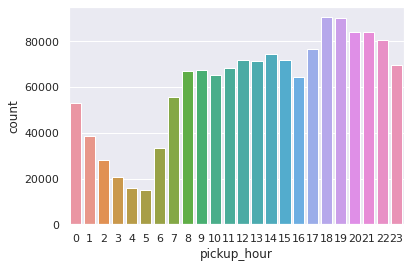

In [102]:
sns.set_theme(style='darkgrid', palette = 'Set2')
sns.countplot(x = nyc_train_data['pickup_hour'])

we see that the rush hours are between 08:00 to 15:00 and from 17:00 to 23:00 


#### Visualization of weekdays to see the most frequent weekdays: 

<AxesSubplot:xlabel='weekdays', ylabel='count'>

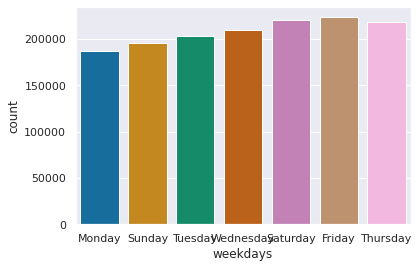

In [103]:

nyc_train_data['weekdays'] = nyc_train_data['pickup_datetime'].dt.strftime('%A')

sns.set_theme(style='darkgrid', palette = 'colorblind')
sns.countplot(x = nyc_train_data['weekdays'])




We see that taxis in New York are mostly used from thursday to saturday



#### Correlation matrix: 


In [104]:
corr_matrix = nyc_train_data.corr().abs()
corr_matrix.style.background_gradient(cmap='coolwarm')

Since we will use a gradient boosting algorithm we will not take any further engineerings based on correlation 




### Visualization of the coordinates: 


In [105]:
pickUp_coordinates = nyc_train_data[['pickup_latitude','pickup_longitude']]
dropOff_coordinates = nyc_train_data[['dropoff_latitude' , 'dropoff_longitude']]

#note that we will just use a small sample
coordinates_test1 = pickUp_coordinates.sample(100000)
coordinates_test2 = dropOff_coordinates.sample(100000)


newYork  = folium.Map(location=[40.730610,-73.935242], zoom_start = 11)

HeatMap(coordinates_test1).add_to(newYork)
HeatMap(coordinates_test2).add_to(newYork)

newYork


### Compute new feature distance with geopy and haversine

(source below) 

In [106]:
# compute trip distance out of pick-up and dropoff: 
# using haversine: 


def haversine(lat1, lon1, lat2, lon2):
     
    # distance between latitudes
    # and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
 
    # convert to radians
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
 
    # apply formulae
    a = (pow(math.sin(dLat / 2), 2) +
         pow(math.sin(dLon / 2), 2) *
             math.cos(lat1) * math.cos(lat2));
    rad = 6371
    c = 2 * math.asin(math.sqrt(a))
    return rad * c

nyc_train_data['distance'] = nyc_train_data.apply(lambda row:haversine(row['pickup_latitude'],row['pickup_longitude'],row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
nyc_train_data['distance'] = nyc_train_data['distance'].astype(float)

# distance is now in kilometers 
nyc_train_data.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  pickup_hour  \
0         40.765602                  N            455           17   
1         40.731152                  N            663            0   
2         40.710087                  N           2124           11   
3         40.706718                  N            429           19   
4         40.782520                  N            435           13   

   dropoff_hour  pickup_minute  dropoff_minute  pickup_second  dropoff_second  \
0            17             24              32             55              30   
1             0             43              54             35              38   
2            12             35              10             24              48   
3            19             32              39             31              40   
4            13             30              38             55              10   

    weekdays  distance  
0     Monday  1.498521  
1     Sunday  1.805507  
2    Tuesday  6.385098  
3  Wednesday  1.485498  
4   Saturday  1.188588

source: https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/


### Visualization of relationship between duration and distance: 

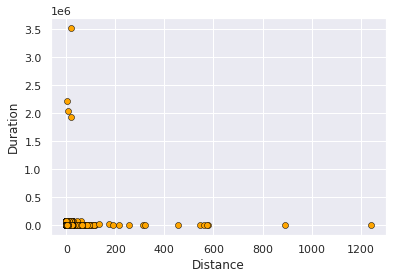

In [107]:
plt.scatter(nyc_train_data['distance'],nyc_train_data['trip_duration'], c = "orange", linewidths = 0.5 , edgecolor = "black")
plt.xlabel("Distance")
plt.ylabel("Duration")
plt.show()


# 2. Training a model: 


In [ ]:
# gradient boosting regression 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

X = nyc_train_data[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'pickup_hour','pickup_minute', 'dropoff_hour','dropoff_minute','distance']]
Y = nyc_train_data['trip_duration'] #label, target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed)
gbrt = GradientBoostingRegressor(max_depth=5, n_estimators=500, learning_rate=0.3, random_state=seed)


gbrt.fit(X_train,y_train)
mean_squared_error(y_test,gbrt.predict(X_test))


